# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク1

## 1.このSprintについて

### Sprintの目的
- スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
- スクラッチで1次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.1次元の畳み込みニューラルネットワークスクラッチ

畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

## 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

## データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [25]:
# ライブラリインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics 
from keras.datasets import mnist
%matplotlib inline

In [26]:
# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [27]:
# テスト実行用
X_train = X_train[:10000, :]
y_train = y_train[:10000]
X_test = X_test[:5000, :]
y_test = y_test[:5000]
X_train.shape

(10000, 784)

## ★ 実行テスト

## 【まとめ】最終的なコード

### ★ScratchDeepNeuralNetrowkClassifier

In [28]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    シンプルな三層ニューラルネットワーク分類器
 
    Parameters
    ----------
    sigma : float
      シグマの値
    lr : float
      学習率
    epoch : int
      エポック数
    verbose : bool
      学習過程表示・非表示
    interval : int
      学習過程の表示間隔
 
    Attributes
    ----------
    """
    def __init__(self, verbose=False, interval=1):
        self.verbose = verbose
        self.interval = interval

    
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        """
        ニューラルネットワーク分類器を学習する。
 
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.inputLayer_nodes = self.n_features
        self.middleLayer1_nodes = 400
        self.middleLayer2_nodes = 200
        self.outputLayer_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = 3
        self.n_filters = 1

        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)

        # ミニバッチのインスタンス生成
        batch_size = 20
        seed = 47

        # 各層・活性化関数のインスタンス生成
        self.FC1 = SimpleConv1d(input_shape = [batch_size, self.n_channels, self.n_features], 
                                initializer = HeInitializer(self.sigma, self.n_channels, self.kernel_size),
                                filters = self.n_filters,
                                kernel_size = self.kernel_size,
                                strides = 2,
                                padding = 'valid',
                                optimizer = optimizer)
        self.activation1 = ReLU()
        self.FC1_output_features = self.FC1.get_output_shape()
        # self.FC1 = FC(SimpleInitializer(self.sigma, self.inputLayer_nodes, self.middleLayer1_nodes), optimizer)
        # self.activation1 = Tanh()
        self.FC2 = FC(HeInitializer(self.sigma, self.FC1_output_features, self.middleLayer2_nodes), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(HeInitializer(self.sigma, self.middleLayer2_nodes, self.outputLayer_nodes), optimizer)
        self.activation3 = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z3 = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activation3.cross_entropy_loss(val_Z3, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


    def add(self):
        """
        ※個人メモ・備忘録
        レイヤー追加用メソッド（追加予定）
        各層のクラス呼び出しをOrderedDictで記述しておく方法に切り替えた方がテスト実行も楽
        """
        pass



    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
 
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
 
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # 推定
        pred = np.argmax(self._forward_propagation(X), axis=1)
        return pred


    def _y_one_hot(self, y):
        """
        yラベルをone-hot化する処理
        """
        y_onehot = np.zeros([len(y), self.outputLayer_nodes])
        for i, yk in enumerate(y):
            y_onehot[i,yk] = 1
        return y_onehot


    def _forward_propagation(self, X):
        """
        フォワードプロパゲーション
        """
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3


    def _back_propagation(self, X, y, Z3):
        """
        バックプロパゲーション
        """
        dA3 = self.activation3.backward(Z3, y) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        _ = self.FC1.backward(dA1)


    def _get_loss(self):
        """
        損失取得処理
        """
        self.loss.append(np.mean(self.activation3.loss))
        self.activation3.loss = []
        if self.is_val:
            self.val_loss.append(np.mean(self.activation3.val_loss))
            self.activation3.val_loss = []


    def _print_loss(self, epoch):
        """
        学習過程表示用
        """
        print('[INFO] epoch : {} / {}'.format(epoch+1, self.epoch))
        print('       Loss(train): {}'.format(self.loss[-1]))
        print('       Loss(test) : {}'.format(self.val_loss[-1]))

### ★ SimpleConv1d

In [29]:
class SimpleConv1d:
    def __init__(self, input_shape, filters=1, kernel_size=3, strides=1, padding='valid', initializer=None, optimizer=None):
        self.input_shape = input_shape  # input_shape = [num_samples, num_channel, len_X]
        self.n_features = int(self.input_shape[2])
        self.n_channels = int(self.input_shape[1])
        self.n_samples = int(self.input_shape[0])
        self.batch_size = self.n_samples
        self.n_filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.initializer = initializer
        self.padding = padding
        self.optimizer = optimizer
    
        # パディング値の設定
        if self.padding == 'valid':
            self.n_padding = 0
        elif self.padding == 'same':
            self.n_padding = self.n_features - ((self.n_features - self.kernel_size) / self.strides + 1)
            assert self.n_padding % 2 == 0, '[ERROR] padding or strides number is incorrect.'
            self.n_padding = int(self.n_padding / 2)

        # フォーワードの出力値の形状 (サンプル数, フィルター数, 畳み込み後の特徴量)
        self.output_shape = np.array([self.n_samples,
                                      self.n_filters,
                                      ((self.n_features + 2*self.n_padding - self.kernel_size) / self.strides) + 1
                                     ]).astype(int)

        # フィルター(w,b)の初期化
        for i in range(self.n_filters):
            tmp_w = self.initializer.W()
            try:
                self.W = np.concatenate([self.W, tmp_w], axis=0)
            except:
                self.W = tmp_w
        self.B = self.initializer.B(self.n_filters)


        self.W = self.W.reshape(self.n_filters, self.n_channels, self.kernel_size)
        self.B = self.B.reshape(1, self.n_filters)

        # AdaGrad用変数
        self.H_W = np.zeros([self.W.shape[1], self.W.shape[2]])
        self.H_B = np.zeros(self.B.shape[1])



    # 順伝播処理
    def forward(self, X):
        self.X = X.copy()

        # パディングの0埋め処理
        if self.n_padding != 0:
            self.X = np.pad(self.X, [[0,0], [self.n_padding, self.n_padding]], 'constant')

        # Xを3次元に調整 (データ数, チャネル数, 特徴量数)
        if self.X.ndim == 1:
            self.X = self.X[np.newaxis, np.newaxis, :]
        elif self.X.ndim == 2:
            if self.n_channels == 1:
                self.X = self.X[:, np.newaxis, :]
            else:
                self.X = self.X[np.newaxis, :, :]
        else:
            pass


        # (データ数, フィルタ数, チャネル1・チャネル2)の順に変換
        tmp1 = []
        self.cols = []
        for idx in range(self.output_shape[2]):
            idx *= self.strides
            if self.n_channels == 1:
                tmp1 = self.X[:, :, idx: idx+self.kernel_size]
            elif self.n_channels == 2:
                tmp1 = np.concatenate([self.X[:, 0, idx: idx+self.kernel_size], 
                                        self.X[:, 1, idx: idx+self.kernel_size]], axis=1)[:, np.newaxis, :]
            elif self.n_channels == 3:
                pass
            try:
                self.cols = np.concatenate([self.cols, tmp1], axis=1)
            except:
                self.cols = tmp1


        # フィルタ毎の計算
        tmp2 = []
        A = []
        for f in range(self.n_filters):
            if self.n_channels == 1:
                # tmp2 = np.sum(cols * self.W[f], axis=2)[:, np.newaxis, :] + self.B[0,f]
                tmp2 = np.sum(self.cols * self.W[f], axis=2) + self.B[0,f]
            elif self.n_channels == 2:
                tmp2 = np.sum(self.cols * np.concatenate([self.W[f], self.W[f]], axis=1), axis=2)[:, np.newaxis, :] + self.B[0,f]
            try:
                A = np.concatenate([A, tmp2], axis=1)
            except:
                A = tmp2
        return A


    def backward(self, dA):
        self.dW = np.sum(dA @ self.cols, axis=(0,1))
        self.dB = np.sum(dA)

        # dZ = np.zeros([self.n_samples, self.n_channels, self.n_features+(2*self.n_padding)])
        # w_cols = self.W * self.cols
        # for idx in range(w_cols.shape[1]):
        #     dZ[:, :, idx:idx+self.kernel_size] += w_cols[:, idx:idx+1, :]

        dZ = np.zeros([self.n_samples, self.n_channels, self.n_features+(2*self.n_padding)])
        for idx in range(self.W.shape[-1]):
            dZ[:, :, idx:idx+dA.shape[-1]] += np.sum(self.W[:,:,idx] * dA, axis=0)

        # 更新
        self.optimizer.update(self)
        return dZ

    def get_output_shape(self):
        # 畳み込み後の特徴量数
        output_features = int(((self.n_features + 2*self.n_padding - self.kernel_size) / self.strides) + 1)
        return output_features

### ★ FC

In [31]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, initializer, optimizer):
        self.optimizer = optimizer
        # w,bの初期化
        self.W = initializer.W()
        self.B = initializer.B()
        self.H_W = np.zeros([self.W.shape[0], self.W.shape[1]])
        self.H_B = np.zeros(self.B.shape[1])

        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.batch_size = X.shape[0]
        self.X = X
        A = X @ self.W + self.B
        return A


    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)
        dZ = dA @ self.W.T
        # 更新
        self.optimizer.update(self)
        return dZ

### ★ Initializer

In [32]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma, n_nodes1, n_nodes2):
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.mean = 0
        self.s = 1

    def W(self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
 
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.normal(loc=self.mean, scale=self.s, size=(self.n_nodes1, self.n_nodes2))
        return W


    def B(self, num=None):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
 
        Returns
        ----------
        B :
        """
        if num == None:
            # B = self.sigma * np.random.normal(loc=self.mean, scale=self.s, size=(1, self.n_nodes2))
            B = np.zeros([1, self.n_nodes2])
        else:
            B = np.zeros([1, num])
        return B


class XavierInitializer(SimpleInitializer):
    def __init__(self, sigma, n_nodes1, n_nodes2):
        super().__init__(sigma, n_nodes1, n_nodes2)
        self.sigma = 1
        self.s = 1 / np.sqrt(n_nodes1)
        pass


class HeInitializer(SimpleInitializer):
    def __init__(self, sigma, n_nodes1, n_nodes2):
        super().__init__(sigma, n_nodes1, n_nodes2)
        self.sigma = 1
        self.s = np.sqrt(2 / self.n_nodes1)
    pass



### ★ Optimizer

In [33]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.batch_size
        layer.B -= self.lr * layer.dB / layer.batch_size

        return layer.W, layer.B

class AdaGrad():
    def __init__(self, lr):
        self.lr = lr
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.H_W += layer.dW * layer.dW / layer.batch_size
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.H_W) + 1e-7) / layer.batch_size

        layer.H_B += layer.dB * layer.dB / layer.batch_size
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.H_B) + 1e-7) / layer.batch_size

        return layer.W, layer.B
    

### ★ Activation

In [34]:
class Softmax:
    def __init__(self):
        self.loss = []
        self.val_loss = []
        pass

    def forward(self, A):
        A -= np.max(A)   # オーバーフロー対策
        self.Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return self.Z

    def backward(self, Z, Y):
        dA = Z - Y
        self.cross_entropy_loss(Z, Y)
        return dA
    
    def cross_entropy_loss(self, Z, Y, val=False):
        batch_size = Z.shape[0]
        delta = 1e-7
        loss = - np.sum(Y * np.log(Z + delta)) / batch_size
        if not val:
            self.loss.append(loss)
        else:
            self.val_loss.append(loss)
        return loss


class Tanh:
    def __init__(self):
        pass

    def forward(self, A):
        self.Z = np.tanh(A)
        return self.Z

    def backward(self, dZ):
        dA = dZ * (1 - dZ**2)
        return dA


class ReLU:
    def __init__(self):
        self.mask = None
        pass

    def forward(self, A):
        self.mask = (A <= 0)
        self.Z = A.copy()
        self.Z[self.mask] = 0
        return self.Z

    def backward(self, dZ):
        dZ[self.mask] = 0
        dA = dZ
        return dA

In [35]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
 
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
  a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

a
i
 : 出力される配列のi番目の値


F
 : フィルタのサイズ


x
(
i
+
s
)
 : 入力の配列の(i+s)番目の値


w
s
 : 重みの配列のs番目の値


b
 : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。


$$
  w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

α
 : 学習率


∂
L
∂
w
s
 : 
w
s
 に関する損失 
L
 の勾配


∂
L
∂
b
 : 
b
 に関する損失 
L
 の勾配


勾配 
∂
L
∂
w
s
 や 
∂
L
∂
b
 を求めるためのバックプロパゲーションの数式が以下です。

 $$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
 $$

 ∂
L
∂
a
i
 : 勾配の配列のi番目の値


N
o
u
t
 : 出力のサイズ


前の層に流す誤差の数式は以下です。


$$
  \frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

∂
L
∂
x
j
 : 前の層に流す誤差の配列のj番目の値


ただし、 
j
−
s
<
0
 または 
j
−
s
>
N
o
u
t
−
1
 のとき 
∂
L
∂
a
(
j
−
s
)
=
0
 です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

```
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```

In [36]:
x = np.array([1,2,3,4,5,6,7])
w = np.array([3, 5, 7])
b = np.array([1])
x.shape[0]

7

## 【解答】

【まとめ】最終コードのSimpleConv1dを参照してください。

## 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
  N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$


N
o
u
t
 : 出力のサイズ（特徴量の数）


N
i
n
 : 入力のサイズ（特徴量の数）


P
 : ある方向へのパディングの数


F
 : フィルタのサイズ


S
 : ストライドのサイズ

## 【解答】

In [37]:
# 出力サイズの計算
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
p = 0
f = 3
s = 1

N_out = (x.shape[0] + 2*p - f / s) + 1
N_out

2.0

## 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

```
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
```

フォワードプロパゲーションをすると出力は次のようになります。

```
a = np.array([35, 50])
```

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

```
delta_a = np.array([10, 20])
```

バックプロパゲーションをすると次のような値になります。

```
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```


## 【解答】

最終版コードのX,W,B,dAの値を問題3にあわせて実行

In [38]:
class TestSimpleConv1d(SimpleConv1d):
    """
    問題3用に一部修正
    """
    def __init__(self, input_shape, filters=1, kernel_size=3, strides=1, padding='valid', initializer=None, optimizer=None):
        self.input_shape = input_shape  # input_shape = [num_samples, num_channel, len_X]
        self.n_features = int(self.input_shape[2])
        self.n_channels = int(self.input_shape[1])
        self.n_samples = int(self.input_shape[0])
        self.batch_size = self.n_samples
        self.n_filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        # self.initializer = initializer
        self.padding = padding
        # self.optimizer = optimizer
    
        # パディング値の設定
        if self.padding == 'valid':
            self.n_padding = 0
        elif self.padding == 'same':
            self.n_padding = self.n_features - ((self.n_features - self.kernel_size) / self.strides + 1)
            assert self.n_padding % 2 == 0, '[ERROR] padding or strides number is incorrect.'
            self.n_padding = int(self.n_padding / 2)

        # フォーワードの出力値の形状 (サンプル数, フィルター数, 畳み込み後の特徴量)
        self.output_shape = np.array([self.n_samples,
                                      self.n_filters,
                                      ((self.n_features + 2*self.n_padding - self.kernel_size) / self.strides) + 1
                                     ]).astype(int)

        # # フィルター(w,b)の初期化
        # for i in range(self.n_filters):
        #     tmp_w = self.initializer.W()
        #     try:
        #         self.W = np.concatenate([self.W, tmp_w], axis=0)
        #     except:
        #         self.W = tmp_w
        # self.B = self.initializer.B(self.n_filters)


        # 問題3用設定
        self.W = np.array([3, 5, 7])
        self.B = b = np.array([1])
        self.W = self.W.reshape(self.n_filters, self.n_channels, self.kernel_size)
        self.B = self.B.reshape(1, self.n_filters)

        # AdaGrad用変数
        self.H_W = np.zeros([self.W.shape[1], self.W.shape[2]])
        self.H_B = np.zeros(self.B.shape[1])

    
    # 順伝播処理
    def forward(self, X):
        self.X = X.copy()

        # パディングの0埋め処理
        if self.n_padding != 0:
            self.X = np.pad(self.X, [[0,0], [self.n_padding, self.n_padding]], 'constant')

        # Xを3次元に調整 (データ数, チャネル数, 特徴量数)
        if self.X.ndim == 1:
            self.X = self.X[np.newaxis, np.newaxis, :]
        elif self.X.ndim == 2:
            if self.n_channels == 1:
                self.X = self.X[:, np.newaxis, :]
            else:
                self.X = self.X[np.newaxis, :, :]
        else:
            pass


        # (データ数, フィルタ数, チャネル1・チャネル2)の順に変換
        tmp1 = []
        self.cols = []
        for idx in range(self.output_shape[2]):
            idx *= self.strides
            if self.n_channels == 1:
                tmp1 = self.X[:, :, idx: idx+self.kernel_size]
            elif self.n_channels == 2:
                tmp1 = np.concatenate([self.X[:, 0, idx: idx+self.kernel_size], 
                                        self.X[:, 1, idx: idx+self.kernel_size]], axis=1)[:, np.newaxis, :]
            elif self.n_channels == 3:
                pass
            try:
                self.cols = np.concatenate([self.cols, tmp1], axis=1)
            except:
                self.cols = tmp1


        # フィルタ毎の計算
        tmp2 = []
        A = []
        for f in range(self.n_filters):
            if self.n_channels == 1:
                # tmp2 = np.sum(cols * self.W[f], axis=2)[:, np.newaxis, :] + self.B[0,f]
                tmp2 = np.sum(self.cols * self.W[f], axis=2) + self.B[0,f]
            elif self.n_channels == 2:
                tmp2 = np.sum(self.cols * np.concatenate([self.W[f], self.W[f]], axis=1), axis=2)[:, np.newaxis, :] + self.B[0,f]
            try:
                A = np.concatenate([A, tmp2], axis=1)
            except:
                A = tmp2
        print(self.cols)
        return A


    def backward(self, dA):

        self.dW = np.sum(dA @ self.cols, axis=(0,1))
        self.dB = np.sum(dA)

        dZ = np.zeros([self.n_samples, self.n_channels, self.n_features+(2*self.n_padding)])
        for idx in range(self.W.shape[-1]):
            dZ[:, :, idx:idx+dA.shape[-1]] += np.sum(self.W[:,:,idx] * dA, axis=0)

        # 更新
        # self.optimizer.update(self)
        return dZ

In [39]:
# 順伝播
x = np.array([1,2,3,4])
sc = TestSimpleConv1d(input_shape=[1, 1, 4], filters=1, kernel_size=3, strides=1, padding='valid')
sc.forward(x)

[[[1 2 3]
  [2 3 4]]]


array([[35, 50]])

In [40]:
# 逆伝播
delta_a = np.array([10, 20])
sc.backward(delta_a)

array([[[ 30., 110., 170., 140.]]])

## 実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
  a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
  \sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

```
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
```

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。


また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

```
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])
```

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。


畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

**《参考》**

以下のページのInteger array indexingの部分がこの方法についての記述です。


Indexing — NumPy v1.17 Manual



## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

例えば以下のようなx, w, bがあった場合は、


```
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）
```

出力は次のようになります。

```
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。
```

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

**《補足》**

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）


今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。




## 【解答】

最終コード・問題３で使用したクラスのW/B/Xの値を修正して実行

※ 下記より、出力チャンネル数 = filter数 = 3 で実行している。

```
self.W = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
```

In [41]:
class TestSimpleConv1d(SimpleConv1d):
    """
    問題4用に一部修正
    """
    def __init__(self, input_shape, filters=1, kernel_size=3, strides=1, padding='valid', initializer=None, optimizer=None):
        self.input_shape = input_shape  # input_shape = [num_samples, num_channel, len_X]
        self.n_features = int(self.input_shape[2])
        self.n_channels = int(self.input_shape[1])
        self.n_samples = int(self.input_shape[0])
        self.batch_size = self.n_samples
        self.n_filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        # self.initializer = initializer
        self.padding = padding
        # self.optimizer = optimizer
    
        # パディング値の設定
        if self.padding == 'valid':
            self.n_padding = 0
        elif self.padding == 'same':
            self.n_padding = self.n_features - ((self.n_features - self.kernel_size) / self.strides + 1)
            assert self.n_padding % 2 == 0, '[ERROR] padding or strides number is incorrect.'
            self.n_padding = int(self.n_padding / 2)

        # フォーワードの出力値の形状 (サンプル数, フィルター数, 畳み込み後の特徴量)
        self.output_shape = np.array([self.n_samples,
                                      self.n_filters,
                                      ((self.n_features + 2*self.n_padding - self.kernel_size) / self.strides) + 1
                                     ]).astype(int)

        # # フィルター(w,b)の初期化
        # for i in range(self.n_filters):
        #     tmp_w = self.initializer.W()
        #     try:
        #         self.W = np.concatenate([self.W, tmp_w], axis=0)
        #     except:
        #         self.W = tmp_w
        # self.B = self.initializer.B(self.n_filters)


        # 問題4用設定
        self.W = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
        self.B = np.array([1, 2, 3]) # （出力チャンネル数）
        self.W = self.W.reshape(self.n_filters, self.n_channels, self.kernel_size)
        self.B = self.B.reshape(1, self.n_filters)

        # AdaGrad用変数
        self.H_W = np.zeros([self.W.shape[1], self.W.shape[2]])
        self.H_B = np.zeros(self.B.shape[1])

    
    # 順伝播処理
    def forward(self, X):
        self.X = X.copy()

        # パディングの0埋め処理
        if self.n_padding != 0:
            self.X = np.pad(self.X, [[0,0], [self.n_padding, self.n_padding]], 'constant')

        # Xを3次元に調整 (データ数, チャネル数, 特徴量数)
        if self.X.ndim == 1:
            self.X = self.X[np.newaxis, np.newaxis, :]
        elif self.X.ndim == 2:
            if self.n_channels == 1:
                self.X = self.X[:, np.newaxis, :]
            else:
                self.X = self.X[np.newaxis, :, :]
        else:
            pass


        # (データ数, フィルタ数, チャネル1・チャネル2)の順に変換
        tmp1 = []
        self.cols = []
        for idx in range(self.output_shape[2]):
            idx *= self.strides
            if self.n_channels == 1:
                tmp1 = self.X[:, :, idx: idx+self.kernel_size]
            elif self.n_channels == 2:
                tmp1 = np.concatenate([self.X[:, 0, idx: idx+self.kernel_size], 
                                        self.X[:, 1, idx: idx+self.kernel_size]], axis=1)[:, np.newaxis, :]
            elif self.n_channels == 3:
                pass
            try:
                self.cols = np.concatenate([self.cols, tmp1], axis=1)
            except:
                self.cols = tmp1


        # フィルタ毎の計算
        tmp2 = []
        A = []
        for f in range(self.n_filters):
            if self.n_channels == 1:
                # tmp2 = np.sum(cols * self.W[f], axis=2)[:, np.newaxis, :] + self.B[0,f]
                tmp2 = np.sum(self.cols * self.W[f], axis=2) + self.B[0,f]
            elif self.n_channels == 2:
                tmp2 = np.sum(self.cols * np.concatenate([self.W[f], self.W[f]], axis=1), axis=2)[:, np.newaxis, :] + self.B[0,f]
            try:
                A = np.concatenate([A, tmp2], axis=1)
            except:
                A = tmp2
        return A


    def backward(self, dA):

        self.dW = np.sum(dA @ self.cols, axis=(0,1))
        self.dB = np.sum(dA)

        dZ = np.zeros([self.n_samples, self.n_channels, self.n_features+(2*self.n_padding)])
        for idx in range(self.W.shape[-1]):
            dZ[:, :, idx:idx+dA.shape[-1]] += np.sum(self.W[:,:,idx] * dA, axis=0)

        # 更新
        # self.optimizer.update(self)
        return dZ

In [42]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])

# 順伝播
sc = TestSimpleConv1d(input_shape=[1, 2, 4], filters=3, kernel_size=3, strides=1, padding='valid')
A = sc.forward(x)

# shape は (サンプル数、出力チャンネル数、特徴量数)としている。
print(A.shape)      
print(A)

(1, 3, 2)
[[[16. 22.]
  [17. 23.]
  [18. 24.]]]


## 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。


numpy.pad — NumPy v1.17 Manual

## 【解答】

padding='valid' のときはパディング=0 となり、
padding='same' のときは、入力サイズと出力サイズが同じになるように実行されるよう作成。

```
■SimpleConv1d の一部抜粋

# パディング値の設定
if self.padding == 'valid':
    self.n_padding = 0
elif self.padding == 'same':
    self.n_padding = self.n_features - ((self.n_features - self.kernel_size) / self.strides + 1)
    assert self.n_padding % 2 == 0, '[ERROR] padding or strides number is incorrect.'
    self.n_padding = int(self.n_padding / 2)
```

以下は padding = 'same'で実行。

In [44]:
class TestScratchDeepNeuralNetrowkClassifier(ScratchDeepNeuralNetrowkClassifier):
    """
    テスト用：ScratchDeepNeuralNetrowkClassifierを継承して必要箇所をオーバーライド
    """
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.inputLayer_nodes = self.n_features
        self.middleLayer1_nodes = 400
        self.middleLayer2_nodes = 200
        self.outputLayer_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = 3
        self.n_filters = 1

        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)

        # ミニバッチのインスタンス生成
        batch_size = 20
        seed = 47

        # 各層・活性化関数のインスタンス生成
        self.FC1 = SimpleConv1d(input_shape = [batch_size, self.n_channels, self.n_features], 
                                initializer = SimpleInitializer(self.sigma, self.n_channels, self.kernel_size),
                                filters = self.n_filters,
                                kernel_size = self.kernel_size,
                                strides = 1,
                                padding = 'same',
                                optimizer = optimizer)
        self.activation1 = Tanh()
        self.FC1_output_features = self.FC1.get_output_shape()
        # self.FC1 = FC(SimpleInitializer(self.sigma, self.inputLayer_nodes, self.middleLayer1_nodes), optimizer)
        # self.activation1 = Tanh()
        self.FC2 = FC(SimpleInitializer(self.sigma, self.FC1_output_features, self.middleLayer2_nodes), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(SimpleInitializer(self.sigma, self.middleLayer2_nodes, self.outputLayer_nodes), optimizer)
        self.activation3 = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z3 = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activation3.cross_entropy_loss(val_Z3, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


In [45]:
dnn5 = TestScratchDeepNeuralNetrowkClassifier(verbose=True, interval=1)
dnn5.fit(X_train, y_train, X_val=X_test, y_val=y_test, sigma=0.01, lr=0.1, epoch=10, optimizer='SGD')

[INFO] epoch : 1 / 10
       Loss(train): 1.023960664831951
       Loss(test) : 1.1027167240674007
[INFO] epoch : 2 / 10
       Loss(train): 0.48196049054820417
       Loss(test) : 0.5759145735704593
[INFO] epoch : 3 / 10
       Loss(train): 0.4142028232656985
       Loss(test) : 0.5292274903456389
[INFO] epoch : 4 / 10
       Loss(train): 0.3725183460922896
       Loss(test) : 0.5087699465270744
[INFO] epoch : 5 / 10
       Loss(train): 0.34145433203528214
       Loss(test) : 0.49500406717842904
[INFO] epoch : 6 / 10
       Loss(train): 0.3505745102131894
       Loss(test) : 0.5180993606422001
[INFO] epoch : 7 / 10
       Loss(train): 0.29142117434281894
       Loss(test) : 0.48588013831877586
[INFO] epoch : 8 / 10
       Loss(train): 0.2698954290837107
       Loss(test) : 0.49290264435209086
[INFO] epoch : 9 / 10
       Loss(train): 0.27094408223251853
       Loss(test) : 0.5077220339306197
[INFO] epoch : 10 / 10
       Loss(train): 0.25765844838590557
       Loss(test) : 0.515324779

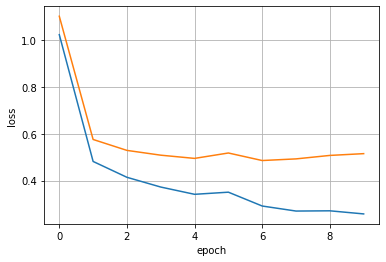

正解率： 0.8824


In [49]:
pred5 = dnn5.predict(X_test)
plt.plot(dnn5.loss)
plt.plot(dnn5.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print('正解率：', metrics.accuracy_score(y_test, pred5))

## 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

## 【解答】

問題4, 5の時点で対応済み

## 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

## 【解答】

以下、ストライド=2で実行

In [50]:
class TestScratchDeepNeuralNetrowkClassifier(ScratchDeepNeuralNetrowkClassifier):
    """
    テスト用：ScratchDeepNeuralNetrowkClassifierを継承して必要箇所をオーバーライド
    """
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.inputLayer_nodes = self.n_features
        self.middleLayer1_nodes = 400
        self.middleLayer2_nodes = 200
        self.outputLayer_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = 3
        self.n_filters = 1

        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)

        # ミニバッチのインスタンス生成
        batch_size = 20
        seed = 47

        # 各層・活性化関数のインスタンス生成
        self.FC1 = SimpleConv1d(input_shape = [batch_size, self.n_channels, self.n_features], 
                                initializer = SimpleInitializer(self.sigma, self.n_channels, self.kernel_size),
                                filters = self.n_filters,
                                kernel_size = self.kernel_size,
                                strides = 2,
                                padding = 'valid',
                                optimizer = optimizer)
        self.activation1 = Tanh()
        self.FC1_output_features = self.FC1.get_output_shape()
        # self.FC1 = FC(SimpleInitializer(self.sigma, self.inputLayer_nodes, self.middleLayer1_nodes), optimizer)
        # self.activation1 = Tanh()
        self.FC2 = FC(SimpleInitializer(self.sigma, self.FC1_output_features, self.middleLayer2_nodes), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(SimpleInitializer(self.sigma, self.middleLayer2_nodes, self.outputLayer_nodes), optimizer)
        self.activation3 = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z3 = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activation3.cross_entropy_loss(val_Z3, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


In [51]:
dnn7 = TestScratchDeepNeuralNetrowkClassifier(verbose=True, interval=1)
dnn7.fit(X_train, y_train, X_val=X_test, y_val=y_test, sigma=0.01, lr=0.1, epoch=10, optimizer='SGD')

[INFO] epoch : 1 / 10
       Loss(train): 1.2098825931773967
       Loss(test) : 1.272229848200606
[INFO] epoch : 2 / 10
       Loss(train): 0.37541887880959834
       Loss(test) : 0.4722422291319804
[INFO] epoch : 3 / 10
       Loss(train): 0.3399609719702984
       Loss(test) : 0.4458295952662452
[INFO] epoch : 4 / 10
       Loss(train): 0.3293649287295434
       Loss(test) : 0.4588069551282904
[INFO] epoch : 5 / 10
       Loss(train): 0.32913210824822553
       Loss(test) : 0.47170054250705234
[INFO] epoch : 6 / 10
       Loss(train): 0.3243863004363754
       Loss(test) : 0.49163893578214
[INFO] epoch : 7 / 10
       Loss(train): 0.3311838272680969
       Loss(test) : 0.5175380147952947
[INFO] epoch : 8 / 10
       Loss(train): 0.3374847869322455
       Loss(test) : 0.5438696864572415
[INFO] epoch : 9 / 10
       Loss(train): 0.32409638231944243
       Loss(test) : 0.5432021228178187
[INFO] epoch : 10 / 10
       Loss(train): 0.3101612736835503
       Loss(test) : 0.54638060221784


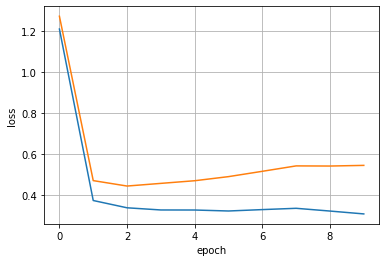

正解率： 0.855


In [52]:
pred7 = dnn7.predict(X_test)
plt.plot(dnn7.loss)
plt.plot(dnn7.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print('正解率：', metrics.accuracy_score(y_test, pred7))

## 3.検証

## 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

### ① SGD・SimpleInitializer・tanh・padding=0・strides=1 で実行

In [53]:
class TestScratchDeepNeuralNetrowkClassifier(ScratchDeepNeuralNetrowkClassifier):
    """
    テスト用：ScratchDeepNeuralNetrowkClassifierを継承して必要箇所をオーバーライド
    """
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.inputLayer_nodes = self.n_features
        self.middleLayer1_nodes = 400
        self.middleLayer2_nodes = 200
        self.outputLayer_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = 3
        self.n_filters = 1

        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)

        # ミニバッチのインスタンス生成
        batch_size = 20
        seed = 47

        # 各層・活性化関数のインスタンス生成
        self.FC1 = SimpleConv1d(input_shape = [batch_size, self.n_channels, self.n_features], 
                                initializer = SimpleInitializer(self.sigma, self.n_channels, self.kernel_size),
                                filters = self.n_filters,
                                kernel_size = self.kernel_size,
                                strides = 1,
                                padding = 'valid',
                                optimizer = optimizer)
        self.activation1 = Tanh()
        self.FC1_output_features = self.FC1.get_output_shape()
        # self.FC1 = FC(SimpleInitializer(self.sigma, self.inputLayer_nodes, self.middleLayer1_nodes), optimizer)
        # self.activation1 = Tanh()
        self.FC2 = FC(SimpleInitializer(self.sigma, self.FC1_output_features, self.middleLayer2_nodes), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(SimpleInitializer(self.sigma, self.middleLayer2_nodes, self.outputLayer_nodes), optimizer)
        self.activation3 = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z3 = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activation3.cross_entropy_loss(val_Z3, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


In [56]:
dnn8_1 = TestScratchDeepNeuralNetrowkClassifier(verbose=True, interval=1)
dnn8_1.fit(X_train, y_train, X_val=X_test, y_val=y_test, sigma=0.01, lr=0.1, epoch=10, optimizer='SGD')

[INFO] epoch : 1 / 10
       Loss(train): 1.1183239128566813
       Loss(test) : 1.1922995934375262
[INFO] epoch : 2 / 10
       Loss(train): 0.4659293563699574
       Loss(test) : 0.5544845292225287
[INFO] epoch : 3 / 10
       Loss(train): 0.44661689499005364
       Loss(test) : 0.546784487979957
[INFO] epoch : 4 / 10
       Loss(train): 0.3926282967253492
       Loss(test) : 0.5184847923369613
[INFO] epoch : 5 / 10
       Loss(train): 0.34720254490938296
       Loss(test) : 0.49282470766900777
[INFO] epoch : 6 / 10
       Loss(train): 0.3544019534818266
       Loss(test) : 0.5087308714588007
[INFO] epoch : 7 / 10
       Loss(train): 0.31616008040925025
       Loss(test) : 0.49653357461246955
[INFO] epoch : 8 / 10
       Loss(train): 0.29417619363006964
       Loss(test) : 0.48486017251376967
[INFO] epoch : 9 / 10
       Loss(train): 0.27428098064869394
       Loss(test) : 0.498105568287434
[INFO] epoch : 10 / 10
       Loss(train): 0.2741932938307498
       Loss(test) : 0.5100169111

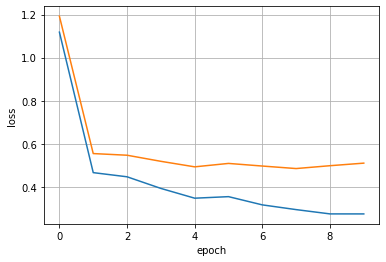

正解率： 0.8804


In [57]:
pred8_1 = dnn8_1.predict(X_test)
plt.plot(dnn8_1.loss)
plt.plot(dnn8_1.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print('正解率：', metrics.accuracy_score(y_test, pred8_1))

### ② AdaGrad・HeInitializer・ReLU・padding=0・strides=1 で実行

In [59]:
class TestScratchDeepNeuralNetrowkClassifier(ScratchDeepNeuralNetrowkClassifier):
    """
    テスト用：ScratchDeepNeuralNetrowkClassifierを継承して必要箇所をオーバーライド
    """
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.inputLayer_nodes = self.n_features
        self.middleLayer1_nodes = 400
        self.middleLayer2_nodes = 200
        self.outputLayer_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = 3
        self.n_filters = 1

        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)

        # ミニバッチのインスタンス生成
        batch_size = 20
        seed = 47

        # 各層・活性化関数のインスタンス生成
        self.FC1 = SimpleConv1d(input_shape = [batch_size, self.n_channels, self.n_features], 
                                initializer = HeInitializer(self.sigma, self.n_channels, self.kernel_size),
                                filters = self.n_filters,
                                kernel_size = self.kernel_size,
                                strides = 1,
                                padding = 'valid',
                                optimizer = optimizer)
        self.activation1 = ReLU()
        self.FC1_output_features = self.FC1.get_output_shape()
        # self.FC1 = FC(SimpleInitializer(self.sigma, self.inputLayer_nodes, self.middleLayer1_nodes), optimizer)
        # self.activation1 = Tanh()
        self.FC2 = FC(HeInitializer(self.sigma, self.FC1_output_features, self.middleLayer2_nodes), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(HeInitializer(self.sigma, self.middleLayer2_nodes, self.outputLayer_nodes), optimizer)
        self.activation3 = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z3 = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activation3.cross_entropy_loss(val_Z3, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


In [60]:
dnn8_2 = TestScratchDeepNeuralNetrowkClassifier(verbose=True, interval=1)
dnn8_2.fit(X_train, y_train, X_val=X_test, y_val=y_test, sigma=0.01, lr=0.1, epoch=10, optimizer='AdaGrad')

[INFO] epoch : 1 / 10
       Loss(train): 0.5967351991829917
       Loss(test) : 0.6899300525138757
[INFO] epoch : 2 / 10
       Loss(train): 0.32799223428158647
       Loss(test) : 0.49800722721314267
[INFO] epoch : 3 / 10
       Loss(train): 0.2672793504154341
       Loss(test) : 0.4707096911375054
[INFO] epoch : 4 / 10
       Loss(train): 0.22670447129011534
       Loss(test) : 0.4563117258999997
[INFO] epoch : 5 / 10
       Loss(train): 0.19796129192354425
       Loss(test) : 0.4485682464864027
[INFO] epoch : 6 / 10
       Loss(train): 0.17635675012011784
       Loss(test) : 0.4442498456703525
[INFO] epoch : 7 / 10
       Loss(train): 0.15875835066460733
       Loss(test) : 0.44234801003109137
[INFO] epoch : 8 / 10
       Loss(train): 0.1441846424807524
       Loss(test) : 0.44172775233686934
[INFO] epoch : 9 / 10
       Loss(train): 0.13087065800256578
       Loss(test) : 0.44135848700574126
[INFO] epoch : 10 / 10
       Loss(train): 0.12219632076353398
       Loss(test) : 0.44105

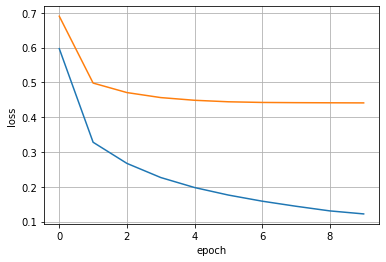

正解率： 0.8644


In [61]:
pred8_2 = dnn8_2.predict(X_test)
plt.plot(dnn8_2.loss)
plt.plot(dnn8_2.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print('正解率：', metrics.accuracy_score(y_test, pred8_2))